# Product Demand Forecasting
Using Facebook's Prophet, we'll be forecasting product demand based on different product categories!

This has real world applications in supplychain management, logistics, and production scheduling.

We'll be using the dataset from https://www.kaggle.com/felixzhao/productdemandforecasting

In [3]:
#Some imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from fbprophet import Prophet

## Importing Data and Cleaning
Keep in mind that to use Facebook's Prophet, we'll need to rename our columns to the appropriate `y` and `ds` naming convention.

In [4]:
raw_data = pd.read_csv('./data/hist_prod_demand.csv')
raw_data.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500


In [5]:
raw_data.info() #This dataset has over 1M rows

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 5 columns):
Product_Code        1048575 non-null object
Warehouse           1048575 non-null object
Product_Category    1048575 non-null object
Date                1037336 non-null object
Order_Demand        1048575 non-null object
dtypes: object(5)
memory usage: 40.0+ MB


In [6]:
raw_data["Order_Demand"].unique() #There seem to be values enclosed in parens

array(['100 ', '500 ', '50000 ', ..., '(3750)', '(191)', '28250 '],
      dtype=object)

In [7]:
#Cleaning and fixing, renaming columns to y & ds for prophet requirements
raw_data['y'] = raw_data['Order_Demand'].str.strip('()').astype(int)
raw_data['ds'] = pd.to_datetime(raw_data['Date'], infer_datetime_format=True)
raw_data.drop(["Date",'Order_Demand'], axis = 1, inplace=True)
raw_data

,Product_Code,Warehouse,Product_Category,y,ds
0,Product_0993,Whse_J,Category_028,100,2012-07-27
1,Product_0979,Whse_J,Category_028,500,2012-01-19
2,Product_0979,Whse_J,Category_028,500,2012-02-03
3,Product_0979,Whse_J,Category_028,500,2012-02-09
4,Product_0979,Whse_J,Category_028,500,2012-03-02
...,...,...,...,...,...
1048570,Product_1791,Whse_J,Category_006,1000,2016-04-27
1048571,Product_1974,Whse_J,Category_006,1,2016-04-27
1048572,Product_1787,Whse_J,Category_006,2500,2016-04-28
1048573,Product_0901,Whse_J,Category_023,50,2016-10-07


In [12]:
len(raw_data["Product_Code"].unique()) #2160 different products

2160

In [13]:
len(raw_data["Product_Category"].unique()) #33 different categories

33

<Figure size 432x288 with 0 Axes>

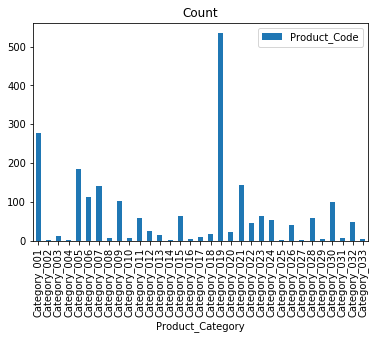

In [14]:
plt.figure()
raw_data.drop_duplicates(subset=["Product_Code"]).groupby("Product_Category").count().plot.bar(y="Product_Code",title="Count")

Some categories seem to only have one product.  We'll see if product category becomes a useful piece of information which we could forecast on.

## Feature Engineering
Let's try and encode the warehouse information.  Perhaps that will be relevant, and we won't want that in a string format.

In [18]:
eng = pd.get_dummies(raw_data, columns=['Warehouse']).drop('Product_Category', axis = 1)

## Splitting Data
We'll be splitting data by product code below.  In order to save time (and not train 2000 models), we'll only be looking at products with the highest number of rows.  This is potentially problematic if we're only attempting to forecast product which have high demand.

By analyzing the results below, we should be able to know whether this was a good decision.

In [19]:
#lets create seperate products dfs and forecast on all of them with more than 1000 rows
prod_dfs = {}

# for prod in raw_data["Product_Code"].unique():
#     curr_df = raw_data[raw_data.Product_Code == prod]      This Code is WAAAY too slow, lets use groupby
#     print(len(curr_df))

prods_w_rows = raw_data.groupby("Product_Code").count().query('ds > 5000').index
for prod in prods_w_rows:
    prod_dfs[prod] = raw_data[raw_data.Product_Code == prod]

print(f'{len(prod_dfs)} products to train on')

18 products to train on


## Forecasting
Facebook (and a lot of other python data science libraries) have made creating, training, and forecasting with models easy.  Below we generate all 18 plots we'll be examining, and then we proceed to plot them while forecasting 5 years into the future.

In [ ]:
for name, df in prod_dfs.items():
    m = Prophet()
    m.fit(df)
    future = m.make_future_dataframe(periods=60, freq='M')
    forecast = m.predict(future)
    fig = m.plot(forecast)
    fig.show()


    